## Problem 3 - Psychopathy

You are interested in causes and treatment options for Psychopathy. You obtained a dataset, contained in the file psychopathy.mat obtained from a prison for violent offenders in upstate New York (not everyone in the prison is a psychopath, but they are more prevalent than in the general population). Each row represents data from one prisoner. All study participants underwent a structural scan with a mobile, truck-mounted MRI. The fiorst data column contains the estimated cortical volume of paralimbic areas, relative to the population median, in cm3. The second column contains the Hare Psychopathy Checklist (PCL-R) scores, which range from 0 to 40 (the higher the score, the more psychopathic traits someone exhibits). These scores are not distributed normally in the general population(median = 4) and definitely not normal in this subpopulation (median = 20). The third column indicates whether they already participated in an experimental treatment program known as ^adecompression therapy^a (0 = did not yet participate, 1 = did already participate). To avoid self-selection effects, everyone in this dataset agreed to the therapy, but prisoner swere randomly assigned to an earlier and a later treatment group, so that the untreated prisoners could serve as a control group.

In [24]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
import math
import random 
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import bootstrap
#Load given data 
load_data = loadmat('psychopathy.mat')
cortical_vol = load_data['DATA'][:,0]
PLCr_scores= load_data['DATA'][:,1]
participation= load_data['DATA'][:,2]
print('loaded the psycopathy data')

loaded the psycopathy data


a) You want to model PCL-R scores as a function of relative volume of paralimbic areas. Use polynomial regression to find a model that best explains the data using cross-validation. What degree does it have? 


The best polynomial model is achieved by a degree of : [1]


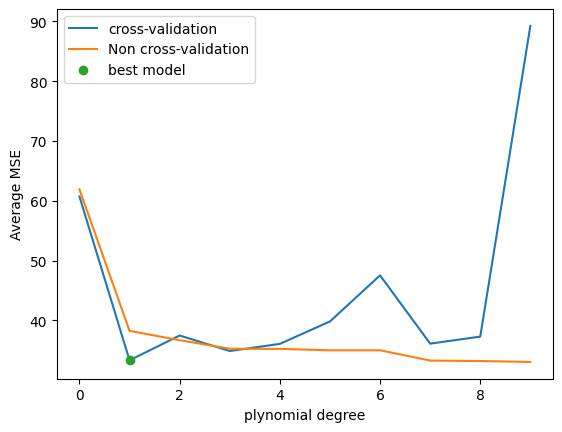

In [22]:
RMSE_allCV = np.zeros((70,10))
RMSE_all = np.zeros((70,10))
for index in range(len(PLCr_scores)):
        # Split data for cross validation (cv)
        cv_index = random.randint(0,len(PLCr_scores)-1)
        scores_test = PLCr_scores[cv_index]
        scores_train = np.delete(PLCr_scores, [cv_index], axis=0)
        vol_test = cortical_vol[cv_index]
        vol_train = np.delete(cortical_vol, [cv_index], axis=0)
        MSE_cv = []
        for i in range(10):
            # Polynomial fit of cv data and non-cv data 
            # non-cv data
            coeffs = np.polyfit(cortical_vol,PLCr_scores,deg = i) # train
            poly_pred = np.poly1d(coeffs)(cortical_vol) # test
            RMSE = mse(PLCr_scores,poly_pred) # evaluate
            # cv data 
            cv_coeffs = np.polyfit(vol_train,scores_train,deg = i) # train 
            cv_poly_pred = np.poly1d(cv_coeffs)(vol_test) # test
            cv_RMSE = mse([scores_test],[cv_poly_pred]) # evaluate
            # append data
            RMSE_allCV[index,i]=cv_RMSE
            RMSE_all[index,i]=RMSE
# calculate average mse 
avg_mseCV = np.mean(RMSE_allCV,axis=0)
avg_mse = np.mean(RMSE_all,axis=0)
# calculate the best polynomial model
best_model = np.amin(avg_mseCV)
best_model_index = np.where(avg_mseCV==best_model)
print('The best polynomial model is achieved by a degree of : {}'.format(best_model_index[0]))
# Plot model degree vs avg mse
fig,ax = plt.subplots()
ax.plot(np.arange(0,10,1),avg_mseCV,label= 'cross-validation')
ax.plot(np.arange(0,10,1),avg_mse,label= 'Non cross-validation')
ax.plot(best_model_index,best_model,'o',label='best model')
# plt.ylim((30,70))
plt.xlabel('plynomial degree')
plt.ylabel('Average MSE')
plt.legend()

b) Use bootstrapping methods to estimate the 95% confidence interval of the average paralimbic volume of the decompression treatment group vs. the control group. If the random assignment worked, the confidence intervals should overlap. Do they? Also, do these data suggest that there is a statistically reliable difference to the general population in terms of paralimbic volume?

Text(0.5, 0, 'Paralimbic Volume [cm^3]')

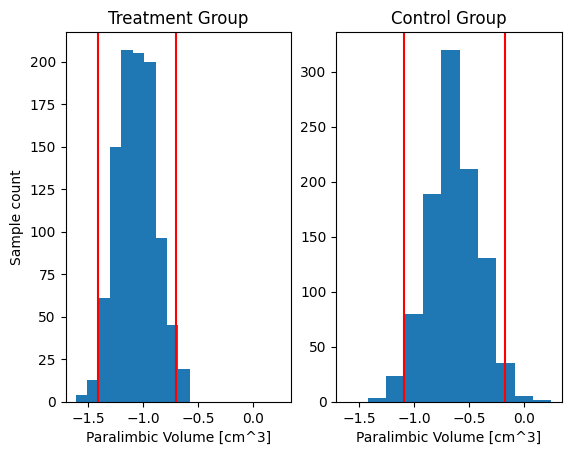

In [74]:
# Split data set into treatment and control subsets
treatment_index = np.where(participation==1)
treatment_data = [cortical_vol[i] for i in treatment_index]
control_index = np.where(participation==0)
control_data = [cortical_vol[i] for i in control_index]
# Obtain 1k bootstrapped samples
treatment_boot = np.zeros((35,1000))
control_boot = np.zeros((35,1000))
for i in range(1000):
  treatment_boot[:,i] = random.choices(treatment_data[0].tolist(), k=len(treatment_data[0]))
  # treatment_avg = np.mean(treatment_boot)
  # treatment_mean.append(treatment_avg)
  control_boot [:,i] = random.choices(control_data[0].tolist(), k=len(control_data[0]))
  # control_avg = np.mean(control_boot)
  # control_mean.append(control_avg)
treatment_avg = np.average(np.array(treatment_boot),axis=0)
control_avg = np.average(np.array(control_boot),axis=0)
# Calculate 95% bootstrapped confidence interval for average pf the paralimbic volume
bootstrap_treatment = bootstrap(treatment_data, np.average, confidence_level=0.95,random_state=1, method='percentile')
bootstrap_control = bootstrap(control_data, np.average, confidence_level=0.95,random_state=1, method='percentile')
fig,ax = plt.subplots(1,2,sharex='all')
# Histogram of mean 
ax[0].hist(treatment_avg)
ax[0].axvline(x = bootstrap_treatment.confidence_interval[0] , color = 'r', label = 'axvline - full height')
ax[0].axvline(x = bootstrap_treatment.confidence_interval[1] , color = 'r', label = 'axvline - full height')
ax[0].set_title('Treatment Group')
ax[0].set_ylabel('Sample count')
ax[0].set_xlabel('Paralimbic Volume [cm^3]')
ax[1].hist(control_avg)
ax[1].axvline(x = bootstrap_control.confidence_interval[0] , color = 'r', label = 'axvline - full height')
ax[1].axvline(x = bootstrap_control.confidence_interval[1] , color = 'r', label = 'axvline - full height')
ax[1].set_title('Control Group')
# ax[1].set_ylabel('Sample count')
ax[1].set_xlabel('Paralimbic Volume [cm^3]')

c) Do a suitable t-test to compare the mean PCL-R score of prisoners who did and did not undergo decompression therapy. What is the p-value? 
d) Do a permutation test to assess whether decompression therapy has an effect. Designate an appropriate test statistic and calculate its exact p value.

In [92]:
# Split data set into treatment and control subsets
treatment_PCLR = [PLCr_scores[i] for i in treatment_index]
control_PCLR = [PLCr_scores[i] for i in control_index]
t_test = stats.ttest_ind(treatment_PCLR[0], control_PCLR[0])
t_permut = stats.ttest_ind(treatment_PCLR[0], control_PCLR[0],permutations=10000)
print('Null hypothesis can not be rejected as p-value={} is > 0.05'.format(t_test[1]))
print('Permutation test (1000 permut)- Null hypothesis can not be rejected as p-value={} is > 0.05'.format(t_permut[1]))


Null hypothesis can not be rejected as p-value=0.08846869073864873 is > 0.05
Permutation test (1000 permut)- Null hypothesis can not be rejected as p-value=0.0886 is > 0.05


The decompression therapy is not effective in reducing the PCL-R scores as no significance difference was found with a confidence of p-value<0.05. Permutation test showed non significant difference.